# Road Traffic Sign Classify Model

The work below attempt to create/evaluate machine learning models and to train a model to classify images of European road traffic signs.

* There are roughly 3500 instances of labelled sign in the dataset.
* There are several models with different performances considerated in this work.


>Author: ***Daniel Dao***

<hr size="5" />

## Table of Contents
* [1. Prerequisite works](#1.-Prerequisite-works)
    * [1.1 Import packages](#1.1-Import-packages)
    * [1.2 Load dataset](#1.2-Load-dataset)
    * [1.3 Evaluation Framework](#1.3-Evaluation-Framework)
* [2. Define the model and train](#2.-Define-the-model-and-train)
    * [2.1 Sign Shape Classification](#2.1-Sign-Shape-Classification)
        * [2.1.1 First model](#2.1.1-First-model)
        * [2.1.2 Regularization](#2.1.2-Regularization)
        * [2.1.3 Dropout](#2.1.3-Dropout)
        * [2.1.4 Extract the hidden layer features and vizualize](#2.1.4-Extract-the-hidden-layer-features-and-vizualize)
        * [2.1.5 Deep CNN network](#2.1.5-Deep-CNN-network)
        * [2.1.6 Predict on random images from test set](#2.1.6-Predict-on-random-images-from-test-set)
    * [2.2 Sign Type Classification](#2.2-Sign-Type-Classification)
        * [2.1.1 First model](#2.1.1-First-model)
        * [2.1.2 Regularization](#2.1.2-Regularization)
        * [2.1.3 Dropout](#2.1.3-Dropout)
        * [2.1.4 Extract the hidden layer features and vizualize](#2.1.4-Extract-the-hidden-layer-features-and-vizualize)
        * [2.1.5 Deep CNN network](#2.1.5-Deep-CNN-network)
        * [2.1.6 Predict on random images from test set](#2.1.6-Predict-on-random-images-from-test-set)
* [3. Independent Evaluation](#3.-Independent-Evaluation)

------

## 1. Prerequisite works

### 1.1 Import packages

In [1]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

import pandas as pd

tf.__version__

'1.15.2'

In [2]:
import glob
import zipfile

In [3]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.manifold import TSNE

### 1.2 Load dataset

In [5]:
with zipfile.ZipFile('trafficsigns_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [6]:
shapes = ['diamond', 'hex', 'round', 'square', 'triangle']

In [7]:
image_list = []
for filepath in glob.glob('./trafficsigns_dataset/*/*/*.png', recursive=True):
    filename = filepath.split("/")[-1]
    shape = filepath.split("/")[-3]
    stype = filepath.split("/")[-2]
    pole = filename.split("_")[0]
    angle = filename.split("_")[1].replace('.png','')
    image_list.append((filepath, shape, stype, pole, angle))
    
# Create a data frame
data = pd.DataFrame(data=image_list, columns=['image_path', 'shape', 'stype', 'pole', 'angle'])
data.head()

,image_path,shape,stype,pole,angle
0,./trafficsigns_dataset/triangle/warning/01556_...,triangle,warning,01556,00002
1,./trafficsigns_dataset/triangle/warning/01083_...,triangle,warning,01083,00001
2,./trafficsigns_dataset/triangle/warning/00195_...,triangle,warning,00195,00000
3,./trafficsigns_dataset/triangle/warning/00024_...,triangle,warning,00024,00002
4,./trafficsigns_dataset/triangle/warning/01782_...,triangle,warning,01782,00002


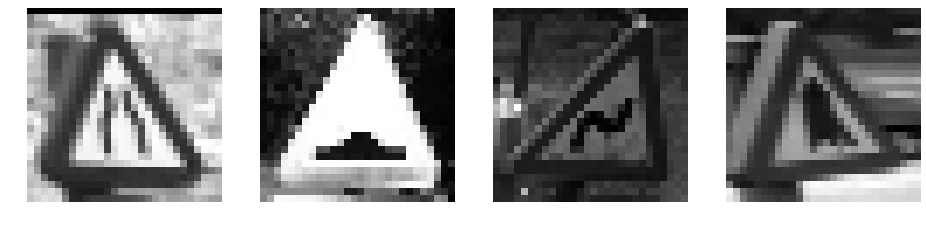

In [8]:
r_inx = np.random.choice(100, 4)
rand_data = data.loc[r_inx,'image_path']

plt.figure(figsize=(16,4))
for i, image_path in enumerate(rand_data):
    im = np.asarray(Image.open(image_path))
    plt.subplot(1,4,i+1)
    plt.imshow(im,cmap='gray')
    plt.axis('off')
    
plt.show()

In [9]:
data.sample(10)

,image_path,shape,stype,pole,angle
2686,./trafficsigns_dataset/diamond/rightofway/0124...,diamond,rightofway,01249,00000
1211,./trafficsigns_dataset/round/noentry/01255_000...,round,noentry,01255,00000
3532,./trafficsigns_dataset/square/parking/01193_00...,square,parking,01193,00001
85,./trafficsigns_dataset/triangle/warning/00454_...,triangle,warning,00454,00000
2347,./trafficsigns_dataset/round/noparking/00452_0...,round,noparking,00452,00001
654,./trafficsigns_dataset/triangle/warning/01682_...,triangle,warning,01682,00000
2220,./trafficsigns_dataset/round/noparking/01659_0...,round,noparking,01659,00002
2050,./trafficsigns_dataset/round/limitedtraffic/00...,round,limitedtraffic,00662,00000
860,./trafficsigns_dataset/triangle/giveway/00133_...,triangle,giveway,00133,00001
1612,./trafficsigns_dataset/round/speed/01820_00000...,round,speed,01820,00000


In [10]:
sh = {'round':0, 'triangle':1, 'square':2, 'diamond':3, 'hex':4}
t = {'rightofway':0, 'stop':1, 'bicycle':2, 'limitedtraffic':3, 'noentry':4, 'noparking':5, 'roundabout':6, 'speed':7, 'trafficdirective':8, 'traveldirection':9, 'continue':10, 'crossing':11, 'laneend':12, 'parking':13, 'giveway':14, 'warning':15}
data['shape_num'] = data['shape'].map(sh, na_action='ignore')
data['stype_num'] = data['stype'].map(t, na_action='ignore')
data['angle'] = pd.to_numeric(data['angle'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3699 entries, 0 to 3698
Data columns (total 7 columns):
image_path    3699 non-null object
shape         3699 non-null object
stype         3699 non-null object
pole          3699 non-null object
angle         3699 non-null int64
shape_num     3699 non-null int64
stype_num     3699 non-null int64
dtypes: int64(3), object(4)
memory usage: 202.4+ KB


In [11]:
data.sample(10)

,image_path,shape,stype,pole,angle,shape_num,stype_num
3524,./trafficsigns_dataset/square/parking/00010_00...,square,parking,00010,1,2,13
2514,./trafficsigns_dataset/round/bicycle/01382_000...,round,bicycle,01382,2,0,2
2674,./trafficsigns_dataset/round/bicycle/00745_000...,round,bicycle,00745,1,0,2
1969,./trafficsigns_dataset/round/traveldirection/0...,round,traveldirection,01661,1,0,9
412,./trafficsigns_dataset/triangle/warning/00859_...,triangle,warning,00859,1,1,15
1070,./trafficsigns_dataset/round/noentry/00560_000...,round,noentry,00560,1,0,4
3024,./trafficsigns_dataset/square/laneend/00766_00...,square,laneend,00766,0,2,12
1476,./trafficsigns_dataset/round/speed/01502_00001...,round,speed,01502,1,0,7
3201,./trafficsigns_dataset/square/continue/01707_0...,square,continue,01707,0,2,10
485,./trafficsigns_dataset/triangle/warning/00365_...,triangle,warning,00365,1,1,15


In [12]:
X = data['image_path']
Y_shape = data['shape_num']
Y_type = data['stype_num']
print(X.shape)
print(Y_shape.unique())
print(Y_type.unique())

(3699,)
[1 0 3 4 2]
[15 14  4  7  6  8  9  3  5  2  0  1 12 10 11 13]


### 1.3 Evaluation Framework 

In [13]:
train_df, validation_df = train_test_split(data, test_size=0.2)
train_df, test_df = train_test_split(train_df, test_size=0.25)
print('Train size: {}, Validate size: {} Test size: {}'.format(train_df.shape, validation_df.shape, test_df.shape))

N_train_images = train_df.shape[0]
N_val_images = validation_df.shape[0]
N_test_images = test_df.shape[0]

Train size: (2219, 7), Validate size: (740, 7) Test size: (740, 7)


## 2. Define the model and train

#### Support functions for training and evaluation

In [14]:
def calculate_losses(model_in, data_generator_in, N_images, batch_size_):
    loss_hold = []
    acc_hold = []
    batches = 0
    
    # iterate over each batch
    for x,y in data_generator_in:
        loss, acc = model_in.evaluate(x, y, verbose=0)
        loss_hold.append(loss)
        acc_hold.append(acc)
        batches += 1
        if batches >= N_images / batch_size_:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break
            
    return np.mean(loss_hold), np.mean(acc_hold)

In [15]:
def train_model(model_, train_generator_in, validation_generator_in, num_epoch=50, verbose=False):
    res = []
    for e in range(num_epoch):
        # print('Epoch', e)
        batches = 0

        loss_ = []
        acc_ = []

         # iterate over each batch
        for x,y in train_generator_in:
            loss, acc = model_.train_on_batch(x, y) # Update weights and return train loss, acc per batch
            loss_.append(loss)
            acc_.append(acc)
            batches += 1
            if batches >= N_train_images / batch_size:
                # we need to break the loop by hand because
                # the generator loops indefinitely
                break
        loss_ = np.mean(loss_)
        acc_ = np.mean(acc_)

        loss, acc = calculate_losses(model_, validation_generator_in, N_val_images, batch_size)
        if verbose:
            print("Training epoch {}: Loss = {}, Accuracy = {}".format(e, loss_, acc_))
            print("Validation epoch {}: Loss = {}, Accuracy = {}".format(e, loss, acc))

        res.append((e, loss_, acc_, loss, acc))
    return np.asarray(res)

In [16]:
def plot_results(res):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(res[:,0], res[:,1], 'r-')
    plt.plot(res[:,0], res[:,3], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.ylim([0, np.max([5., np.max(res[:,1]), np.max(res[:,3])])])

    plt.subplot(1,2,2)
    plt.plot(res[:,0], res[:,2], 'r-')
    plt.plot(res[:,0], res[:,4], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, np.max([1., np.max(res[:,2]), np.max(res[:,4])])])

### 2.1 Sign Shape Classification

In [17]:
shape_train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
shape_val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
shape_test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 16

shape_train_generator = shape_train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory='./',
        x_col="image_path",
        y_col="shape",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

shape_validation_generator = shape_val_datagen.flow_from_dataframe(
        dataframe=validation_df,
        directory='./',
        x_col="image_path",
        y_col="shape",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')


batch_size_t = 1

shape_test_generator = shape_test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory='./',
        x_col="image_path",
        y_col="shape",
        target_size=(28, 28),
        batch_size=batch_size_t,
        class_mode='categorical')

Found 2219 validated image filenames belonging to 5 classes.
Found 740 validated image filenames belonging to 5 classes.
Found 740 validated image filenames belonging to 5 classes.


#### 2.1.1 First Model

In [18]:
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

shape_model = Sequential()
shape_model.add(Flatten(input_shape=(28, 28, 3)))
shape_model.add(Dense(64))
shape_model.add(Activation('relu'))
shape_model.add(Dense(5))
shape_model.add(Activation('softmax'))


# Compile model
shape_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=[categorical_accuracy])
shape_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2352)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                150592    
_________________________________________________________________
activation (Activation)      (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
_________________________________________________________________
activation_1 (Activation)    (None, 5)                 0         
Total params: 150,917
Trainable params: 150,917
Non-trainable params: 0
_________________________________________________________________


In [19]:
res = train_model(shape_model, shape_train_generator, shape_validation_generator, num_epoch=250, verbose=False)

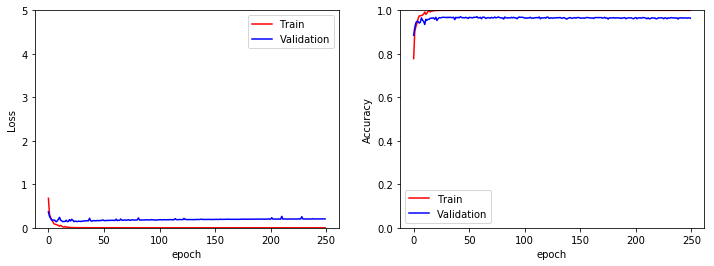

In [20]:
plot_results(res)

#### 2.1.2 Regularization

Lets add some ridge penalty and create a new model

In [21]:
# Input layer
input_ = Input(shape=(28, 28, 3)) # This is the input shape
input_slice = Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))(input_)
x = Flatten()(input_slice)  # This will convert the 28x28 input to a vector of  dimension 784

# Hidden layer
h = Dense(64,kernel_regularizer=regularizers.l2(0.01))(x) # reg for weight matrix 1
h = Activation('relu', name='hidden_layer')(h)

# Output layer
out_ = Dense(5,kernel_regularizer=regularizers.l2(0.01))(h) # reg for weight matrix 2
out_ = Activation('softmax')(out_)

# Define model
shape_model_reg = Model(inputs=input_, outputs=out_)

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
shape_model_reg.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])


shape_model_reg.summary()

# Creating a model for feature vizualization
hidden_features = Model(inputs=input_, outputs=h)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 3)]       0         
_________________________________________________________________
lambda (Lambda)              (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                50240     
_________________________________________________________________
hidden_layer (Activation)    (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
_________________________________________________________________
activation_2 (Activation)    (None, 5)                 0     

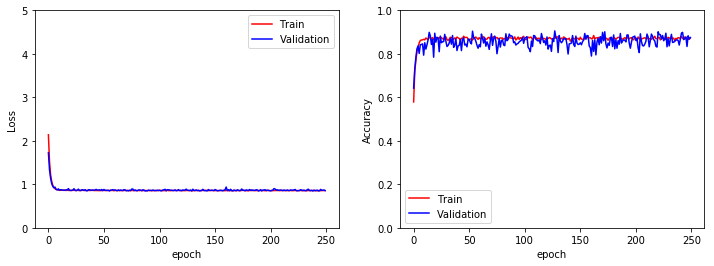

In [22]:
res = train_model(shape_model_reg, shape_train_generator, shape_validation_generator, num_epoch=250, verbose=False)
plot_results(res)

#### 2.1.3 Dropout

Lets create a model with dropput and see if that can also help with overfitting (no regularization)

In [23]:
# Input layer
input_ = Input(shape=(28, 28, 3)) # This is the input shape
input_slice = Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))(input_)
x = Flatten()(input_slice)  # This will convert the 28x28 input to a vector of  dimension 784

# Hidden layer
h = Dense(64)(x) 
h = Activation('relu')(h)
h= Dropout(rate=0.5)(h)

# Output layer
out_ = Dense(5)(h) 
out_ = Activation('softmax')(out_)

# Define model
shape_model_drop = Model(inputs=input_, outputs=out_)

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
shape_model_drop.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])


shape_model_drop.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 3)]       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                50240     
_________________________________________________________________
activation_3 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 325 

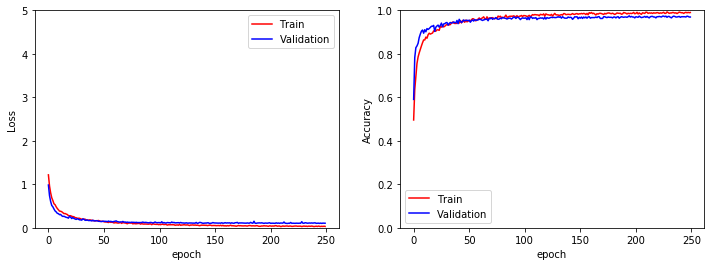

In [24]:
res = train_model(shape_model_drop, shape_train_generator, shape_validation_generator, num_epoch=250, verbose=False)
plot_results(res)

#### 2.1.4 Extract the hidden layer features and vizualize

In [25]:
#print layer names
for layer in hidden_features.layers:
    print(layer.name)


def extract_hidden_features(model_, generator_, N_images): 
    batches = 0

    features = []
    inputs = []
    y_ = []

    # iterate over each batch
    for x,y in generator_:
        hf = model_.predict(x) 
        for h in hf:
            features.append(h)
        for yy in y:
            y_.append(np.argmax(yy))
        for xx in x:
            inputs.append(xx.reshape(-1,))

        batches += 1
        if batches >= N_images / batch_size:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break 
    features = np.asarray(features)
    y = np.asarray(y_)
    inputs = np.asarray(inputs)
    
    return inputs, y, features

input_1
lambda
flatten_1
dense_2
hidden_layer


Text(0.5, 1.0, 'Input Embedding')

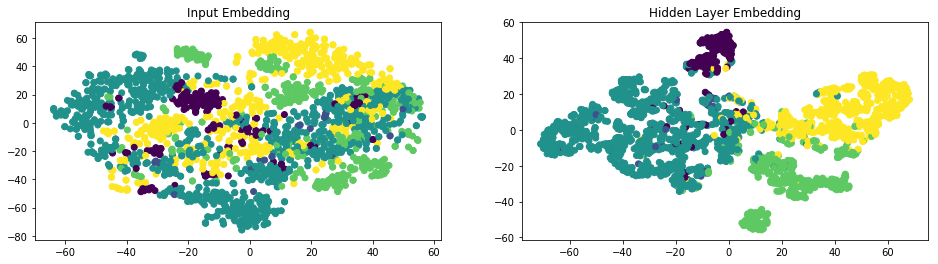

In [26]:
inputs, y, features = extract_hidden_features(hidden_features, shape_train_generator, N_train_images)

plt.figure(figsize=(16,4))
plt.subplot(1,2,2)
features_embedded = TSNE(n_components=2).fit_transform(features)
plt.scatter(features_embedded[:,0], features_embedded[:,1], c=y)
plt.title('Hidden Layer Embedding')

plt.subplot(1,2,1)
inputs_embedded = TSNE(n_components=2).fit_transform(inputs)
plt.scatter(inputs_embedded[:,0], inputs_embedded[:,1], c=y)
plt.title('Input Embedding')

Now lets plot for test data

Text(0.5, 1.0, 'Input Embedding')

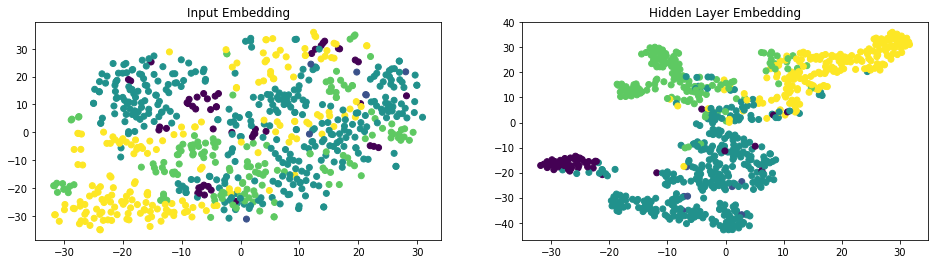

In [27]:
inputs, y, features = extract_hidden_features(hidden_features, shape_validation_generator, N_val_images)

plt.figure(figsize=(16,4))
plt.subplot(1,2,2)
features_embedded = TSNE(n_components=2).fit_transform(features)
plt.scatter(features_embedded[:,0], features_embedded[:,1], c=y)
plt.title('Hidden Layer Embedding')

plt.subplot(1,2,1)
inputs_embedded = TSNE(n_components=2).fit_transform(inputs)
plt.scatter(inputs_embedded[:,0], inputs_embedded[:,1], c=y)
plt.title('Input Embedding')

What does the above two plots tell you about overfitting?

#### 2.1.5 Deep CNN network 

In [28]:
shape_train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last', 
                                   rotation_range=15, width_shift_range=0.2, 
                                   height_shift_range=0.2)
batch_size = 16

shape_train_generator = shape_train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory='./',
        x_col="image_path",
        y_col="shape",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 2219 validated image filenames belonging to 5 classes.


In [29]:
shape_model_cnn = Sequential()
shape_model_cnn.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001), input_shape=(28, 28, 3)))
shape_model_cnn.add(Activation('relu'))
shape_model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

shape_model_cnn.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
shape_model_cnn.add(Activation('relu'))

shape_model_cnn.add(Conv2D(64, (3, 3)))
shape_model_cnn.add(Activation('relu'))
shape_model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

shape_model_cnn.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
shape_model_cnn.add(Dense(64))
shape_model_cnn.add(Activation('relu'))
shape_model_cnn.add(Dropout(0.5))
shape_model_cnn.add(Dense(5))
shape_model_cnn.add(Activation('softmax'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
shape_model_cnn.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])

shape_model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        896       
_________________________________________________________________
activation_5 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
activation_6 (Activation)    (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          18496     
_________________________________________________________________
activation_7 (Activation)    (None, 9, 9, 64)         

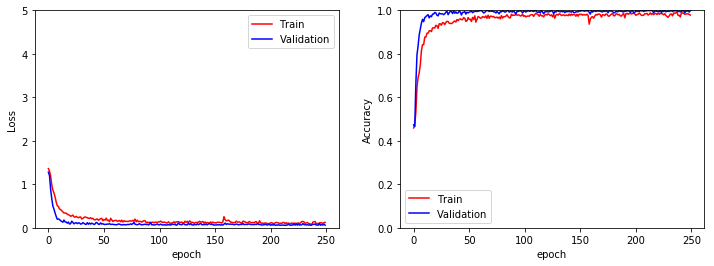

In [30]:
res = train_model(shape_model_cnn, shape_train_generator, shape_validation_generator, num_epoch=250, verbose=False)
plot_results(res)

#### 2.1.6 Predict on random images from test set

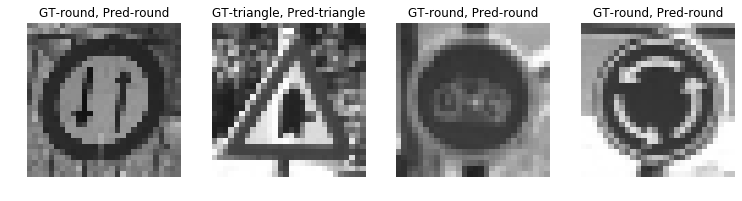

In [31]:
shape_d_test_inv = {0: 'diamond', 1: 'hex', 2: 'round', 3: 'square', 4: 'triangle'}
plt.figure(figsize=(16,4))
batches = 0
for x,y in shape_test_generator:
        batches = batches + 1
        y_hat = shape_model_cnn.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(shape_d_test_inv[np.argmax(y[0])], shape_d_test_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

In [32]:
print(shape_d_test_inv)
print(sh)

{0: 'diamond', 1: 'hex', 2: 'round', 3: 'square', 4: 'triangle'}
{'round': 0, 'triangle': 1, 'square': 2, 'diamond': 3, 'hex': 4}


### 2.2 Sign Type Classification

In [33]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 16

type_train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory='./',
        x_col="image_path",
        y_col="stype",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

type_validation_generator = val_datagen.flow_from_dataframe(
        dataframe=validation_df,
        directory='./',
        x_col="image_path",
        y_col="stype",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')


batch_size_t = 1

type_test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory='./',
        x_col="image_path",
        y_col="stype",
        target_size=(28, 28),
        batch_size=batch_size_t,
        class_mode='categorical')

Found 2219 validated image filenames belonging to 16 classes.
Found 740 validated image filenames belonging to 16 classes.
Found 740 validated image filenames belonging to 16 classes.


#### 2.2.1 First model

In [34]:
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

type_model = Sequential()
type_model.add(Flatten(input_shape=(28, 28, 3)))
type_model.add(Dense(64))
type_model.add(Activation('relu'))
type_model.add(Dense(16))
type_model.add(Activation('softmax'))


# Compile model
type_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=[categorical_accuracy])
type_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 2352)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                150592    
_________________________________________________________________
activation_10 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                1040      
_________________________________________________________________
activation_11 (Activation)   (None, 16)                0         
Total params: 151,632
Trainable params: 151,632
Non-trainable params: 0
_________________________________________________________________


In [35]:
res = train_model(type_model, type_train_generator, type_validation_generator, num_epoch=250, verbose=False)

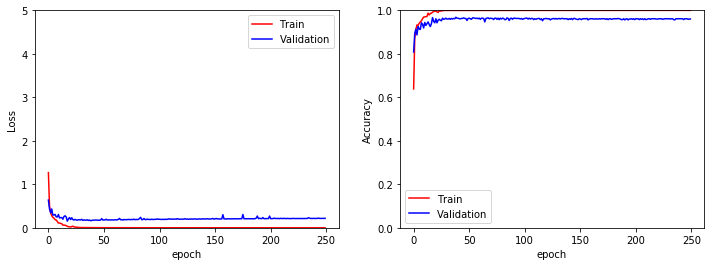

In [36]:
plot_results(res)

#### 2.2.2 Regularization

Lets add some ridge penalty and create a new model

In [37]:
# Input layer
input_ = Input(shape=(28, 28, 3)) # This is the input shape
input_slice = Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))(input_)
x = Flatten()(input_slice)  # This will convert the 28x28 input to a vector of  dimension 784

# Hidden layer
h = Dense(64,kernel_regularizer=regularizers.l2(0.01))(x) # reg for weight matrix 1
h = Activation('relu', name='hidden_layer')(h)

# Output layer
out_ = Dense(16,kernel_regularizer=regularizers.l2(0.01))(h) # reg for weight matrix 2
out_ = Activation('softmax')(out_)

# Define model
type_model_reg = Model(inputs=input_, outputs=out_)

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
type_model_reg.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])


type_model_reg.summary()

# Creating a model for feature vizualization (will be explained later)
hidden_features = Model(inputs=input_, outputs=h)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 3)]       0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                50240     
_________________________________________________________________
hidden_layer (Activation)    (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 16)                1040      
_________________________________________________________________
activation_12 (Activation)   (None, 16)                0   

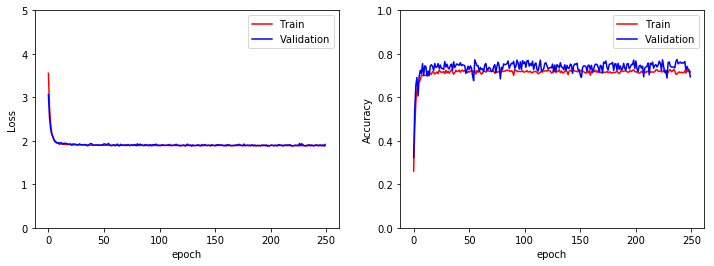

In [38]:
res = train_model(type_model_reg, type_train_generator, type_validation_generator, num_epoch=250, verbose=False)
plot_results(res)

#### 2.2.3 Dropout

Lets create a model with dropput and see if that can also help with overfitting (no regularization)

In [39]:
# Input layer
input_ = Input(shape=(28, 28, 3)) # This is the input shape
input_slice = Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))(input_)
x = Flatten()(input_slice)  # This will convert the 28x28 input to a vector of  dimension 784

# Hidden layer
h = Dense(64)(x) 
h = Activation('relu')(h)
h= Dropout(rate=0.5)(h)

# Output layer
out_ = Dense(16)(h) 
out_ = Activation('softmax')(out_)

# Define model
type_model_drop = Model(inputs=input_, outputs=out_)

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
type_model_drop.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])


type_model_drop.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 3)]       0         
_________________________________________________________________
lambda_3 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                50240     
_________________________________________________________________
activation_13 (Activation)   (None, 64)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 16)                1040

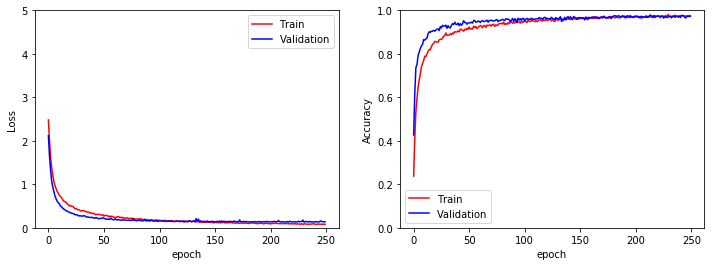

In [40]:
res = train_model(type_model_drop, type_train_generator, type_validation_generator, num_epoch=250, verbose=False)
plot_results(res)

#### 2.2.4 Extract the hidden layer features and vizualize

In [41]:
#print layer names
for layer in hidden_features.layers:
    print(layer.name)


def extract_hidden_features(model_, generator_, N_images): 
    batches = 0

    features = []
    inputs = []
    y_ = []

    # iterate over each batch
    for x,y in generator_:
        hf = model_.predict(x) 
        for h in hf:
            features.append(h)
        for yy in y:
            y_.append(np.argmax(yy))
        for xx in x:
            inputs.append(xx.reshape(-1,))

        batches += 1
        if batches >= N_images / batch_size:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break 
    features = np.asarray(features)
    y = np.asarray(y_)
    inputs = np.asarray(inputs)
    
    return inputs, y, features

input_3
lambda_2
flatten_5
dense_10
hidden_layer


Text(0.5, 1.0, 'Input Embedding')

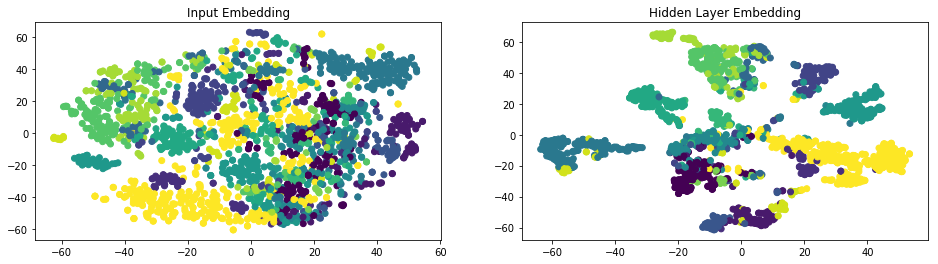

In [42]:
inputs, y, features = extract_hidden_features(hidden_features, type_train_generator, N_train_images)

plt.figure(figsize=(16,4))
plt.subplot(1,2,2)
features_embedded = TSNE(n_components=2).fit_transform(features)
plt.scatter(features_embedded[:,0], features_embedded[:,1], c=y)
plt.title('Hidden Layer Embedding')

plt.subplot(1,2,1)
inputs_embedded = TSNE(n_components=2).fit_transform(inputs)
plt.scatter(inputs_embedded[:,0], inputs_embedded[:,1], c=y)
plt.title('Input Embedding')

Text(0.5, 1.0, 'Input Embedding')

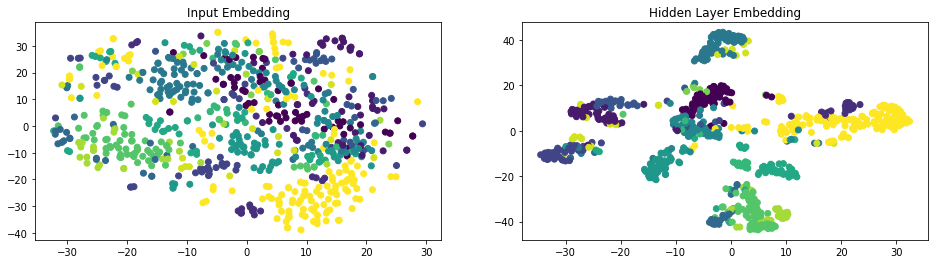

In [43]:
inputs, y, features = extract_hidden_features(hidden_features, type_validation_generator, N_val_images)

plt.figure(figsize=(16,4))
plt.subplot(1,2,2)
features_embedded = TSNE(n_components=2).fit_transform(features)
plt.scatter(features_embedded[:,0], features_embedded[:,1], c=y)
plt.title('Hidden Layer Embedding')

plt.subplot(1,2,1)
inputs_embedded = TSNE(n_components=2).fit_transform(inputs)
plt.scatter(inputs_embedded[:,0], inputs_embedded[:,1], c=y)
plt.title('Input Embedding')

#### 2.1.5 Deep CNN network

In [44]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last', 
                                   rotation_range=15, width_shift_range=0.2, 
                                   height_shift_range=0.2)

batch_size = 16

type_train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory='./',
        x_col="image_path",
        y_col="stype",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 2219 validated image filenames belonging to 16 classes.


In [45]:
type_model_cnn = Sequential()
type_model_cnn.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001), input_shape=(28, 28, 3)))
type_model_cnn.add(Activation('relu'))
type_model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

type_model_cnn.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
type_model_cnn.add(Activation('relu'))
# model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

type_model_cnn.add(Conv2D(64, (3, 3)))
type_model_cnn.add(Activation('relu'))
type_model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

type_model_cnn.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
type_model_cnn.add(Dense(64))
type_model_cnn.add(Activation('relu'))
type_model_cnn.add(Dropout(0.5))
type_model_cnn.add(Dense(16))
type_model_cnn.add(Activation('softmax'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
type_model_cnn.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])

type_model_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        896       
_________________________________________________________________
activation_15 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
activation_16 (Activation)   (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 9, 9, 64)          18496     
_________________________________________________________________
activation_17 (Activation)   (None, 9, 9, 64)         

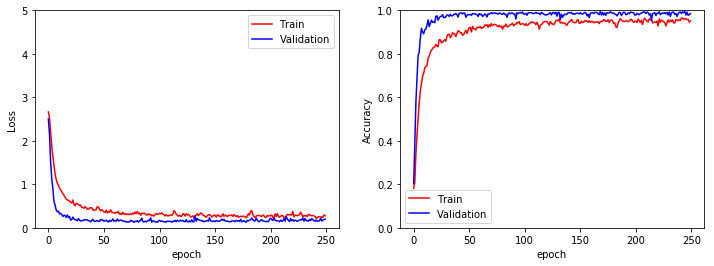

In [46]:
res = train_model(type_model_cnn, type_train_generator, type_validation_generator, num_epoch=250, verbose=False)
plot_results(res)

#### 2.1.6 Predict on random images from test set

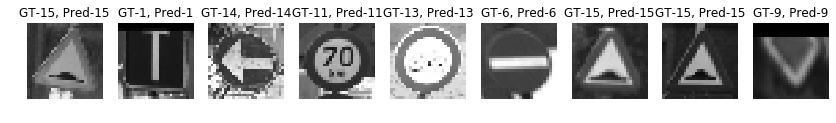

In [47]:
type_d_test_inv = {0: 'rightofway', 1: 'continue', 2: 'bicycle', 3: 'limitedtraffic', 4: 'laneend', 5: 'noparking', 6: 'roundabout', 7: 'speed', 8: 'trafficdirective', 9: 'traveldirection', 10: 'continue', 11: 'crossing', 12: 'laneend', 13: 'parking', 14: 'traveldirection', 15: 'warning'}
plt.figure(figsize=(16,4))
batches = 0
for x,y in type_test_generator:
        batches = batches + 1
        y_hat = type_model.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 10:
            plt.subplot(1,10,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(np.argmax(y[0]), np.argmax(y_hat[0])))
            
        else:
            break
        
        plt.axis('off')

## 3.Independent Evaluation

In [48]:
with zipfile.ZipFile('independent_evaluation.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [49]:
independent_image_list = []
for filepath in glob.glob('./independent_evaluation/*/*/*.png', recursive=True):
    filename = filepath.split("/")[-1]
    shape = filepath.split("/")[-3]
    stype = filepath.split("/")[-2]
#     pole = filename.split("_")[0]
#     angle = filename.split("_")[1].replace('.png','')
#     independent_image_list.append((filepath, shape, stype, pole, angle))
    independent_image_list.append((filepath, shape, stype))
    
# Create a data frame
independent_data = pd.DataFrame(data=independent_image_list, columns=['image_path', 'shape', 'stype'])
independent_data.head()

,image_path,shape,stype
0,./independent_evaluation/triangle/giveway/i03_...,triangle,giveway
1,./independent_evaluation/triangle/giveway/i05_...,triangle,giveway
2,./independent_evaluation/triangle/giveway/i04_...,triangle,giveway
3,./independent_evaluation/triangle/giveway/i01_...,triangle,giveway
4,./independent_evaluation/triangle/giveway/i02_...,triangle,giveway


In [50]:
sh = {'round':0, 'triangle':1, 'square':2, 'diamond':3, 'hex':4}
t = {'rightofway':0, 'stop':1, 'bicycle':2, 'limitedtraffic':3, 'noentry':4, 'noparking':5, 'roundabout':6, 'speed':7, 'trafficdirective':8, 'traveldirection':9, 'continue':10, 'crossing':11, 'laneend':12, 'parking':13, 'giveway':14, 'warning':15}
independent_data['shape_num'] = independent_data['shape'].map(sh, na_action='ignore')
independent_data['stype_num'] = independent_data['stype'].map(t, na_action='ignore')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3699 entries, 0 to 3698
Data columns (total 7 columns):
image_path    3699 non-null object
shape         3699 non-null object
stype         3699 non-null object
pole          3699 non-null object
angle         3699 non-null int64
shape_num     3699 non-null int64
stype_num     3699 non-null int64
dtypes: int64(3), object(4)
memory usage: 202.4+ KB


In [51]:
independent_X = independent_data['image_path']
independent_Y_shape = independent_data['shape_num']
independent_Y_type = independent_data['stype_num']
print(independent_X.shape)
print(independent_Y_shape.unique())
print(independent_Y_type.unique())

(25,)
[1 0 3 4 2]
[14  5  0  1 11]


In [52]:
independent_N_images = independent_data.shape[0]

### 3.1 Test Shape Model

In [53]:
independent_shape_test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size_t = 1

independent_shape_test_generator = independent_shape_test_datagen.flow_from_dataframe(
        dataframe=independent_data,
        directory='./',
        x_col="image_path",
        y_col="shape",
        target_size=(28, 28),
        batch_size=batch_size_t,
        class_mode='categorical')

Found 25 validated image filenames belonging to 5 classes.


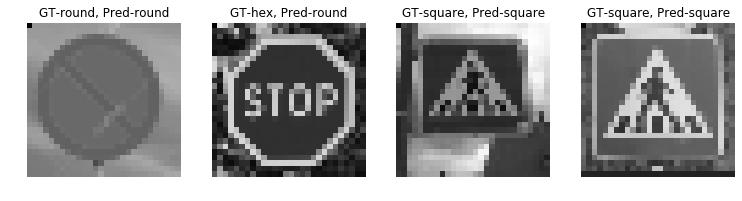

In [54]:
shape_d_test_inv = {0: 'diamond', 1: 'hex', 2: 'round', 3: 'square', 4: 'triangle'}
plt.figure(figsize=(16,4))
batches = 0
for x,y in independent_shape_test_generator:
        batches = batches + 1
        y_hat = shape_model_cnn.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(shape_d_test_inv[np.argmax(y[0])], shape_d_test_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

### 3.2 Test Type Model

In [55]:
independent_type_test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size_t = 1

independent_type_test_generator = independent_type_test_datagen.flow_from_dataframe(
        dataframe=independent_data,
        directory='./',
        x_col="image_path",
        y_col="stype",
        target_size=(28, 28),
        batch_size=batch_size_t,
        class_mode='categorical')

Found 25 validated image filenames belonging to 5 classes.


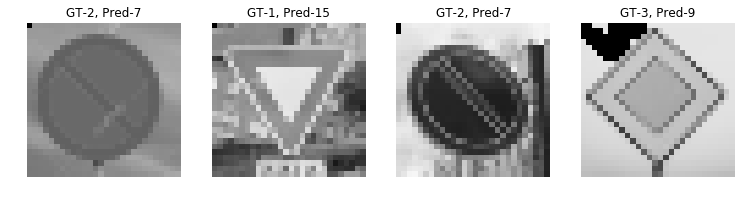

In [56]:
type_d_test_inv = {0: 'rightofway', 1: 'continue', 2: 'bicycle', 3: 'limitedtraffic', 4: 'laneend', 5: 'noparking', 6: 'roundabout', 7: 'speed', 8: 'trafficdirective', 9: 'traveldirection', 10: 'continue', 11: 'crossing', 12: 'laneend', 13: 'parking', 14: 'traveldirection', 15: 'warning'}
plt.figure(figsize=(16,4))
batches = 0
for x,y in independent_type_test_generator:
        batches = batches + 1
        y_hat = type_model.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(np.argmax(y[0]), np.argmax(y_hat[0])))
            
        else:
            break
        
        plt.axis('off')